<a href="https://colab.research.google.com/github/hossein20s/PPG2bloodPressure/blob/master/PPG2BloodPressure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# S0

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
REPO_NAME = 'PPG2bloodPressure'
%run gdrive/My\ Drive/lib/connect.ipynb


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
Tensorflow Version:  1.13.1
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Vesion:1.4
mkdir: cannot create directory ‘/content/gdrive/My Drive/src/’: File exists
fatal: destination path 'PPG2bloodPressure' already exists and is not an empty directory.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * 

In [2]:
BUCKET_DIR = 'gs://medicalblockchain_dev'
!gsutil cp $BUCKET_DIR/data/BP_PPG_ECG/Part_1.mat /tmp/data1.mat

Copying gs://medicalblockchain_dev/data/BP_PPG_ECG/Part_1.mat...
/ [1 files][811.9 MiB/811.9 MiB]                                                
Operation completed over 1 objects/811.9 MiB.                                    


# S2 Apply LSTM based model

Check out https://machinelearningmastery.com/encoder-decoder-attention-sequence-to-sequence-prediction-keras/


In [26]:
%run gdrive/My\ Drive/lib/models.lib.ipynb
#%run gdrive/My\ Drive/lib/data.io.lib.ipynb

import json
jsonfile = REPO_DIR + '/config.2dense.json'
configs = json.load(open(jsonfile, 'r'))

data = DataLoader(
	os.path.join('data', configs['data']['filename']),
	configs['data']['train_test_split'],
	configs['data']['columns']
)
model = theModel()
model.build_model(configs)

models.lib Version:  2.7
['#refs#', 'Part_1']
2
PPG
ABP
(61000, 2)
(3000, 2)
        PPG        ABP
0  1.759531  67.062955
1  1.718475  69.358628
2  1.684262  75.366453
[Model] Model Compiled
[1]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                128       
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________
Time taken: 0:00:00.210209


In [27]:

data = DataLoader(
	os.path.join('data', configs['data']['filename']),
	configs['data']['train_test_split'],
	configs['data']['columns']
)


x, y = data.get_base_train_data(
	seq_len = configs['data']['sequence_length'],
	normalise = configs['data']['normalise']
)



['#refs#', 'Part_1']
2
PPG
ABP
(61000, 2)
(3000, 2)
        PPG        ABP
0  1.759531  67.062955
1  1.718475  69.358628
2  1.684262  75.366453


(2550, 1)
(2550,)
        PPG
1 -0.198834
2 -0.254392


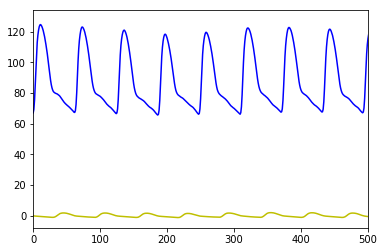

In [28]:
import matplotlib.pyplot as plt

print(x.shape)
print(y.shape)
print(x[1:3])

def _plot0(x, y):
  plt.plot(x, 'y')
  plt.plot(y,'b')
  plt.xlim(0,500)
#  plt.ylim(ymin, ymax)
  plt.show()


def _plot(x, y):
  plt.plot(x, 'y')
  plt.plot(y[0],'b')
  plt.plot(y[1],'g')
  plt.ylim(-3,3)
  plt.show()
def _ploty(x, y, ymin, ymax):
  plt.plot(x, 'y')
  plt.plot(y,'b')
  plt.ylim(ymin, ymax)
  plt.show()
  
#_plot(data.data_train[1:100,0], x[:,:,0])
#_ploty(data.data_train[1:100,1], y[1:100,0], 50, 150)
_plot0(x,y)

In [0]:

import matplotlib.pyplot as plt

print(x.shape)
print(y.shape)
print(len(x))
print(x[1][1:3])
print(y)
plt.plot(data.data_test)
plt.show()
plt.plot(x[0])
plt.plot(x[1])


#x = x.reshape(2500,1,49)
#y = y.reshape(2500,1)
#print(x[0,0])


LSTM layer is a recurrent layer, hence it expects a 3-dimensional input (batch_size, timesteps, input_dim).

[Model] Training Started
[Model] 20 epochs, 1 batch size

....................[Model] Training Completed. Model saved as /tmp/26052019-035435-e20.h5
Time taken: 0:00:49.099096


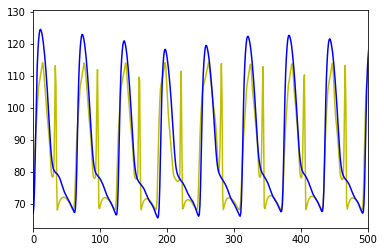

In [30]:
#print(x[0:2])
#reshaped_x = x.reshape(x.shape[0], x.shape[2], x.shape[1])
#print(reshaped_x.shape)
#print(reshaped_x[0:2])
# in-memory training


model.train(
  x,
  y,
  epochs = 20, #configs['training']['epochs'],
  batch_size = 1,#configs['training']['batch_size'],
  save_dir = configs['model']['save_dir']
)
'''
# out-of memory generative training
steps_per_epoch = math.ceil((data.len_train - configs['data']['sequence_length']) / configs['training']['batch_size'])
model.train_generator(
    data_gen=data.generate_train_batch(
        seq_len=configs['data']['sequence_length'],
        batch_size=configs['training']['batch_size'],
        normalise=configs['data']['normalise']
    ),
    epochs=configs['training']['epochs'],
    batch_size=configs['training']['batch_size'],
    steps_per_epoch=steps_per_epoch,
    save_dir=configs['model']['save_dir']
)

'''

predict_train_y = model.model.predict(x)
_plot0(predict_train_y,y)
#_ploty(predict_train[1:500,0], y[1:500,0], 88, 89)



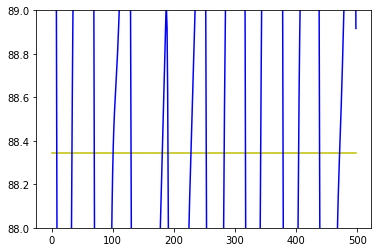

In [75]:
_ploty(predict_train[1:500,0], y[1:500,0], 88, 89)


Version 2.3
(400, 50, 1)
(400, 1)


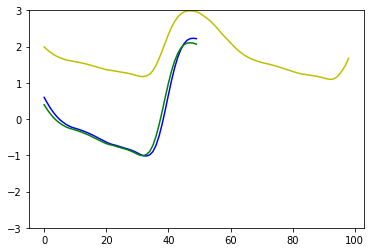

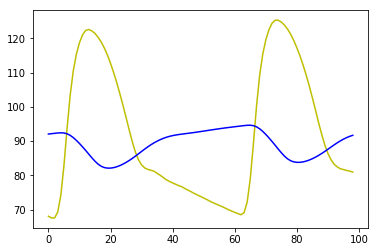

In [64]:
%run gdrive/My\ Drive/lib/graph.lib.ipynb

x_test, y_test = data.seq2seq_test_data(
    seq_len=configs['data']['sequence_length'],
    normalise=configs['data']['normalise']
)

print(x_test.shape)
print(y_test.shape)
  
_plot(data.data_test[1:100,0], x_test[:,:,0])
_ploty(data.data_test[1:100,1], y_test[1:100,0])



In [22]:
predict_test = model.model.predict(x_test)
print(predict_test.shape)


(400, 1)


(2500, 1)
(2500, 1)


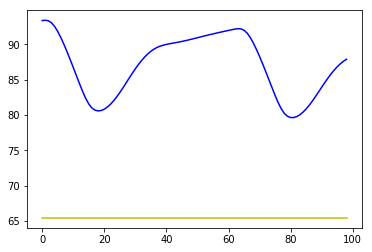

[-3.655703e-06]


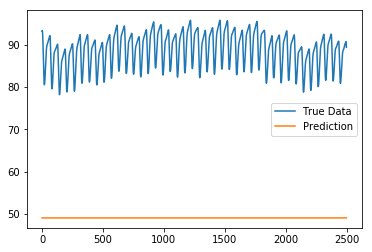

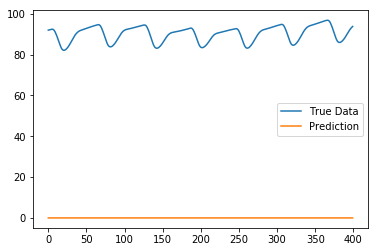

In [34]:
print(predict_test[5])
plot_results(predict_train, y)
plot_results(predict_test, y_test)
#calculate_errors(y_test, predictions)

# predictions = model.predict_sequence_full(x_test, configs['data']['sequence_length'])


In [0]:
predictions = model.predict_sequence_full(x_test, configs['data']['sequence_length'])


[Model] Predicting Sequences Full...


[Model] Predicting Sequences Multiple...


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

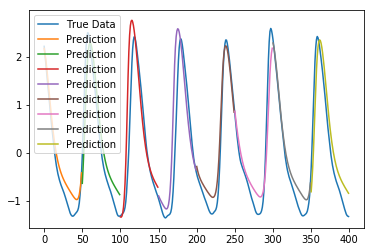

In [0]:
predictions = model.predict_sequences_multiple(x_test, configs['data']['sequence_length'], configs['data']['sequence_length'])
plot_results_multiple(predictions, y_test, configs['data']['sequence_length'])


# S1 applying old models

In [9]:
def build_2DenslyConnectedModel():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[1]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

model = build_2DenslyConnectedModel()
model.summary()



Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________


In [104]:
print(train_dataset.shape)
print(train_labels.shape)

print(x.shape)
print(y.shape)

xx = x[:,0,:].reshape(x.shape[0])
print(xx[1:5])

d = { 'PPG':xx }
train_x = pd.DataFrame(d)

print(train_x[1:5])
print(y[1:5])
print(train_dataset[1:5])
print(train_labels[1:5])
print(train_x.shape)
print(y.shape)
train_y = y.reshape(y.shape[0]) 
print(train_y.shape)
print(train_y[1:5])


(48000, 1)
(48000,)
(2500, 50, 1)
(2500, 1)
[-0.10532762 -0.18672473 -0.25291177 -0.30799564]
        PPG
1 -0.105328
2 -0.186725
3 -0.252912
4 -0.307996
[[93.33815262]
 [93.3879736 ]
 [93.31079992]
 [93.03238853]]
        PPG
1  1.718475
2  1.684262
3  1.657869
4  1.637341
[69.35862807 75.36645289 85.03758554 96.22288542]
(2500, 1)
(2500, 1)
(2500,)
[93.33815262 93.3879736  93.31079992 93.03238853]


In [170]:
%run gdrive/My\ Drive/lib/models.lib.ipynb

EPOCHS = 2000

history = model.fit(
  x, y,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

models.lib Version:  2.6

........................................

KeyboardInterrupt: ignored

In [122]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
1995,5.124848,1.723907,5.124848,6.487871,2.149484,6.487871,1995
1996,5.114344,1.716588,5.114344,5.823632,2.005230,5.823633,1996
1997,5.040305,1.711038,5.040305,3.765936,1.567619,3.765936,1997
1998,5.097846,1.721367,5.097845,7.652155,2.381031,7.652155,1998
1999,5.090778,1.723251,5.090778,4.307600,1.674071,4.307600,1999


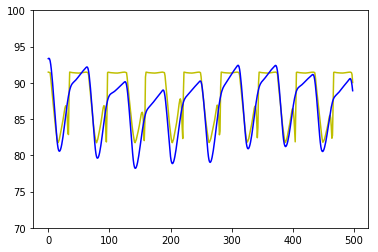

In [123]:
predict_train_y = model.predict(train_x)
_ploty(predict_train_y[1:500], train_y[1:500], 70, 100)


In [124]:
calculate_errors(train_y, predict_train_y)

explained_variance_score 0.6858418815689646
mean_absolute_error 1.825415887433182
mean_squared_error 5.4251764195689915
mean_squared_log_error 0.0006838158165254816
median_absolute_error 1.581162237058642


# Old
__________

Some data can also be found here. No Idea the realtionship
https://drive.google.com/drive/u/0/mobile/folders/154j5jxudI3PAvPDjPiscs-P3Q5ZRpq5t?usp=drive_open

Maybe figure it out from 
https://sites.google.com/view/cufflessbp/dataset?authuser=0


In [78]:
with h5py.File('/tmp/data1.mat', 'r') as f:
  print(list(f.keys()))
  ds = f['Part_1']
  print(ds.shape)
  x = ds[0][0]
  #print(x.dtype)
  print(f[x].shape)
  print(f[x].dtype)
  ppg_abp_ecg = f[x][:]
  print(ppg_abp_ecg.shape)
  


['#refs#', 'Part_1']
(3000, 1)
(61000, 3)
float64
(61000, 3)


In [0]:
ppg = ppg_abp_ecg[:,0]
abp = ppg_abp_ecg[:,1]
ecg = ppg_abp_ecg[:,2]
  

[[ 1.75953079e+00  6.70629552e+01 -6.06060606e-02]
 [ 1.71847507e+00  6.93586281e+01 -7.52688172e-02]
 [ 1.68426197e+00  7.53664529e+01 -7.03812317e-02]
 ...
 [ 1.64418377e+00  7.64410232e+01 -1.00195503e-01]
 [ 1.60019550e+00  8.18138747e+01 -9.04203324e-02]
 [ 1.56598240e+00  9.13873191e+01 -4.54545455e-02]]


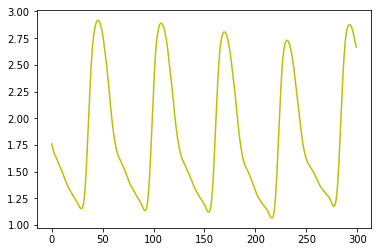

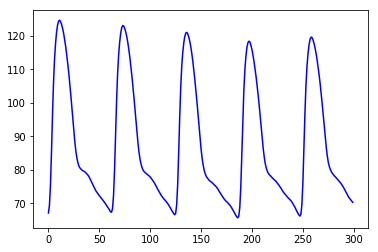

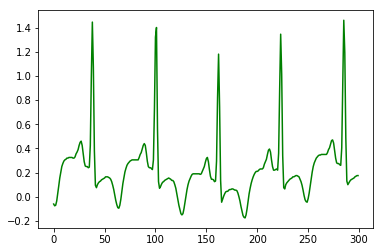

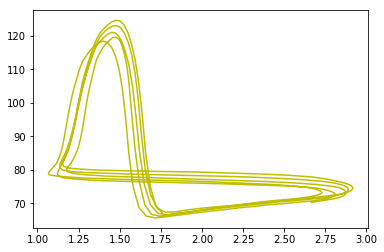

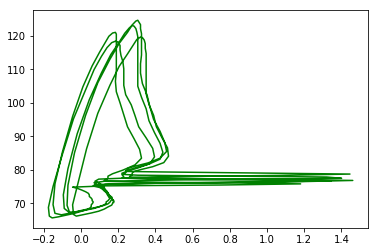

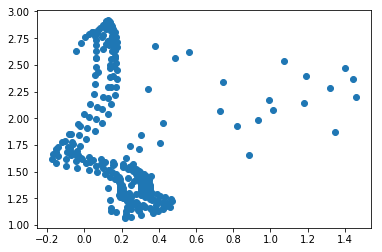

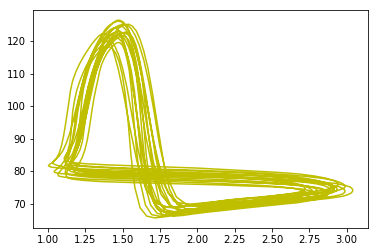

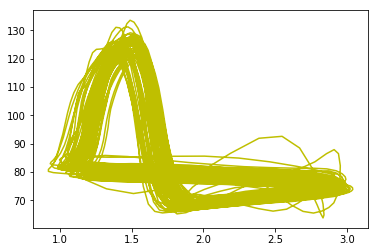

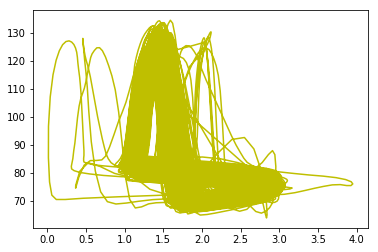

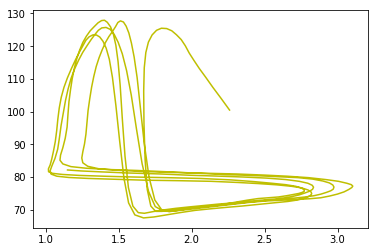

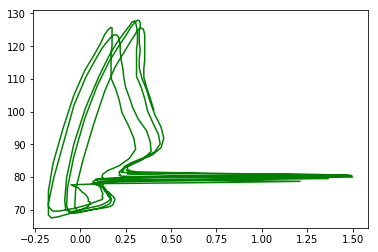

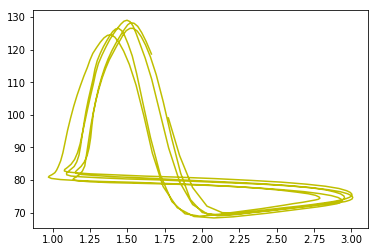

In [80]:
  print(ppg_abp_ecg)
  
  import numpy as np
  
  n = 300
  x = np.arange(n)
  i= 0
  import matplotlib.pyplot as plt
  plt.plot(x, ppg[i:i+n], 'y')
  plt.show()
  plt.plot(x, abp[i:i+n], 'b')
  plt.show()
  plt.plot(x, ecg[i:i+n], 'g')
  plt.show()

  n = 300
  i = 0
  plt.plot(ppg[i:i+n], abp[i:i+n], 'y')
  plt.show()
  plt.plot(ecg[i:i+n], abp[i:i+n], 'g')
  plt.show()
  plt.plot(ecg[i:i+n], ppg[i:i+n], 'o')
  plt.show()

  n = 1000
  plt.plot(ppg[i:i+n], abp[i:i+n], 'y')
  plt.show()
  n = 4000
  plt.plot(ppg[i:i+n], abp[i:i+n], 'y')
  plt.show()
  n = 20000
  plt.plot(ppg[i:i+n], abp[i:i+n], 'y')
  n = 300
  i = 1000
  plt.plot(ppg[i:i+n], abp[i:i+n], 'y')
  plt.show()
  i = 10000
  plt.plot(ppg[i:i+n], abp[i:i+n], 'y')
  plt.show()
  plt.plot(ecg[i:i+n], abp[i:i+n], 'g')
  plt.show()
  i = 20000
  plt.plot(ppg[i:i+n], abp[i:i+n], 'y')
  plt.show()



# red dashes, blue squares and green triangles
#plt.plot(t, t, 'r--', t, t**2, 'bs', t, t**3, 'g^')


# Prediction

lets predict 1000 timeslice from the first 6000 one.
First we create a dataframe from the first 7000 

In [0]:
import numpy as np
import pandas as pd
n = 60000
index = np.arange(n)
columns = ['PPG', 'ABP']
df = pd.DataFrame(index=index, columns=columns)

df['PPG'] = ppg[0:n]
df['ABP'] = abp[0:n]


In [82]:
#train = df.sample(frac=0.8, random_state=1)
train_len = int(.8*n)
print(train_len)
train = df[0:train_len]
test = df.drop(train.index)


48000


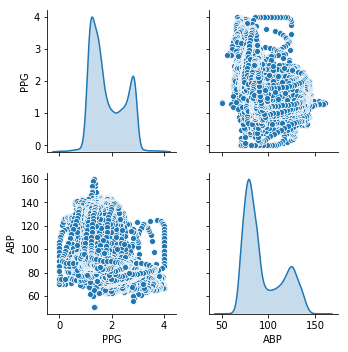

In [0]:
import seaborn as  sns
sns.pairplot(train[['PPG', 'ABP']], diag_kind='kde')

In [89]:
train_dataset = train.copy()
test_dataset = test.copy()
print(train_dataset.describe())

train_stats = train.describe()
train_stats.pop("ABP")
train_stats = train_stats.transpose()
print(train_stats)

train_labels = train_dataset.pop('ABP').values
test_labels = test_dataset.pop('ABP').values
print(train_labels.shape)
print(test_labels)


                PPG           ABP
count  48000.000000  48000.000000
mean       1.842939     94.244440
std        0.633437     20.580400
min        0.000000     50.162895
25%        1.312805     78.199411
50%        1.635386     86.063312
75%        2.419599    112.536816
max        4.001955    160.110974
       count      mean       std  min       25%       50%       75%       max
PPG  48000.0  1.842939  0.633437  0.0  1.312805  1.635386  2.419599  4.001955
(48000,)
[81.61849824 81.47196593 81.1789013  ... 82.59538032 81.86271876
 81.2277454 ]


In [85]:
len(train_dataset.keys())

1

In [95]:
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

NameError: ignored

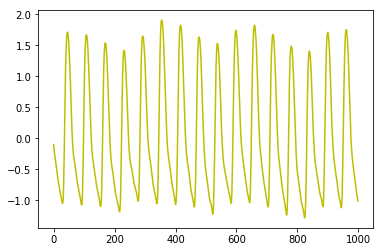

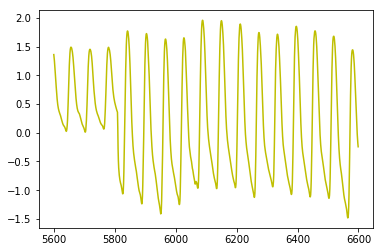

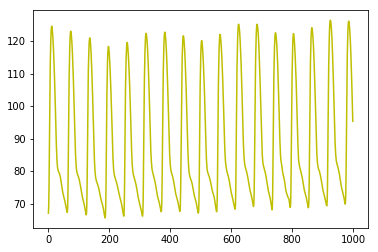

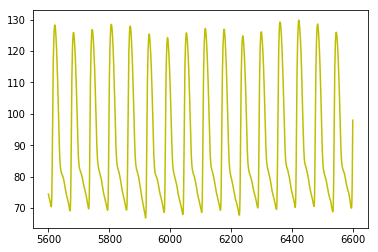

In [0]:
n = 1000
i = 0
plt.plot(normed_train_data[i:i+n], 'y')
plt.show()
plt.plot(normed_test_data[i:i+n], 'y')
plt.show()
plt.plot(train_labels[i:i+n], 'y')
plt.show()
plt.plot(test_labels[i:i+n], 'y')
plt.show()


# Building Densly Connected Model

data.io.lib Version:  1.8
['#refs#', 'Part_1']
2
PPG
ABP
        PPG        ABP
0  1.759531  67.062955
1  1.718475  69.358628
2  1.684262  75.366453
[Model] Model Compiled
Time taken: 0:00:00.667758
0 97.93242906614958
0 94.22027714144765
0 89.72661954838742
0 85.47718247668917
0 83.81648293142777
0 85.1841178510548
0 85.62371478950634
0 80.93468077935654
0 74.04766207694901
0 70.62857477788144
0 70.23782194370229
0 69.94475731806793
0 70.28666604797469
0 72.48465074023241
0 74.43841491112816


In [0]:
model.summary()

Check to be sure the formats are correct

In [0]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[0.01318312],
       [0.02159481],
       [0.02860457],
       [0.03401209],
       [0.03821793],
       [0.04262407],
       [0.04723047],
       [0.05183689],
       [0.056243  ],
       [0.06084941]], dtype=float32)

In [0]:
%run gdrive/My\ Drive/lib/models.lib.ipynb

EPOCHS = 20

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................

In [0]:
%run gdrive/My\ Drive/lib/graph.lib.ipynb

plt = plot_results_multiple(predictions, y_test, configs['data']['sequence_length'])
# plot_results(predictions, y_test)
plt.xlim(100, 500)
plt.show()

In [0]:
print(len(x_test))

9100


In [0]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
15,199.005581,10.208893,199.005554,145.199803,9.202450,145.199844,15
16,198.978996,10.205048,198.979141,140.468326,8.757236,140.468353,16
17,199.024113,10.200797,199.024048,141.705036,8.839198,141.705093,17
18,199.140670,10.194422,199.140640,146.972996,9.036280,146.973038,18
19,199.085152,10.206981,199.085068,145.415492,8.939301,145.415482,19


In [0]:
%run gdrive/My\ Drive/lib/graphlib.ipynb

In [0]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  #plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()

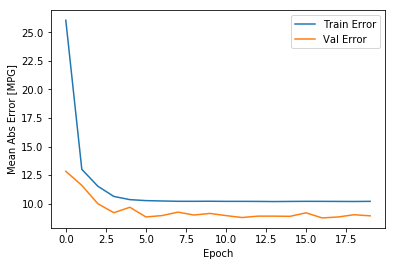

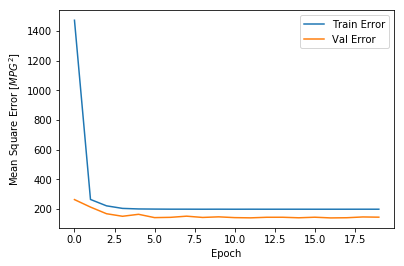

In [0]:
plot_history(history)

In [0]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

Testing set Mean Abs Error:  9.14 MPG


# Finally Prediction

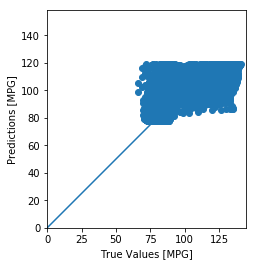

In [0]:
predicted_labels = model.predict(normed_test_data)

plt.scatter(test_labels, predicted_labels)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

KeyboardInterrupt: ignored

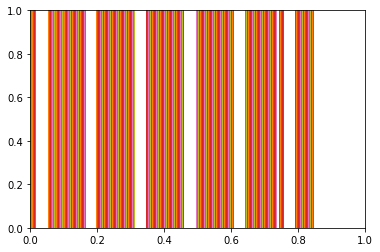

In [0]:
error = predicted_labels - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
- = plt.ylabel("Count")

# Try conventionl Methods
Starting with Random Forest

In [0]:
# Code taken from Josh Bloom's lecture

from sklearn.ensemble import RandomForestRegressor
clf2 = RandomForestRegressor(n_estimators=1000, 
                            criterion='mse')
clf2.fit(normed_train_data, train_labels)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [0]:
predicted_labels = clf2.predict(normed_test_data)


(0, 200)

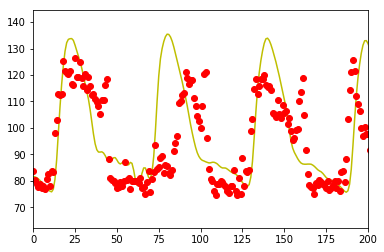

In [0]:

# try plotting the actual delta fluxes vs the predicted
plt.plot(test_labels[i:i+n], 'y')
plt.plot(predicted_labels[0:1000],'ro')
plt.xlim([0, 200])

In [0]:
calculate_errors(test_labels, predicted_labels)

explained_variance_score 0.49241515868229035
mean_absolute_error 9.241145617852025
mean_squared_error 188.17109519689743
mean_squared_log_error 0.02003685775762599
median_absolute_error 5.800709786540139


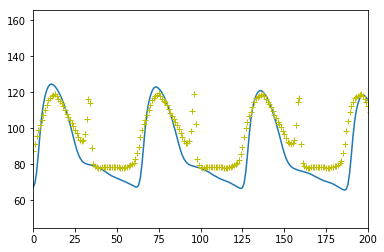

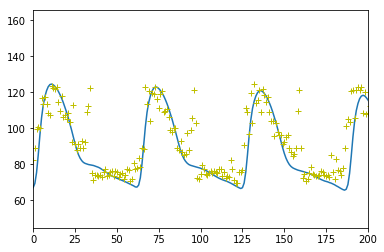

In [0]:
# now let's draw the predictions for the entire training dataset... stupid to do?

predicted_train_labels = model.predict(normed_train_data)
plt.plot(train_labels)
plt.plot(predicted_train_labels , 'y+')
plt.xlim([0,200])
plt.show()
predicted_train_labels = clf2.predict(normed_train_data)
plt.plot(train_labels)
plt.plot(predicted_train_labels , 'y+')
plt.xlim([0,200])
plt.show()